In [ ]:
# https://stackoverflow.com/questions/48180041/how-can-i-use-multiple-dimensional-polynomials-with-numpy-polynomial

In [1]:
import numpy as np
from scipy.linalg import lstsq
from scipy.special import binom

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def _get_coeff_idx(coeff):
    idx = np.indices(coeff.shape)
    idx = idx.T.swapaxes(0, 1).reshape((-1, 2))
    return idx


def _scale(x, y):
    # Normalize x and y to avoid huge numbers
    # Mean 0, Variation 1
    offset_x, offset_y = np.mean(x), np.mean(y)
    norm_x, norm_y = np.std(x), np.std(y)
    x = (x - offset_x) / norm_x
    y = (y - offset_y) / norm_y
    return x, y, (norm_x, norm_y), (offset_x, offset_y)


def _unscale(x, y, norm, offset):
    x = x * norm[0] + offset[0]
    y = y * norm[1] + offset[1]
    return x, y


def polyvander2d(x, y, degree):
    A = np.polynomial.polynomial.polyvander2d(x, y, degree)
    return A


def polyscale2d(coeff, scale_x, scale_y, copy=True):
    if copy:
        coeff = np.copy(coeff)
    idx = _get_coeff_idx(coeff)
    for k, (i, j) in enumerate(idx):
        coeff[i, j] /= scale_x ** i * scale_y ** j
    return coeff


def polyshift2d(coeff, offset_x, offset_y, copy=True):
    if copy:
        coeff = np.copy(coeff)
    idx = _get_coeff_idx(coeff)
    # Copy coeff because it changes during the loop
    coeff2 = np.copy(coeff)
    for k, m in idx:
        not_the_same = ~((idx[:, 0] == k) & (idx[:, 1] == m))
        above = (idx[:, 0] >= k) & (idx[:, 1] >= m) & not_the_same
        for i, j in idx[above]:
            b = binom(i, k) * binom(j, m)
            sign = (-1) ** ((i - k) + (j - m))
            offset = offset_x ** (i - k) * offset_y ** (j - m)
            coeff[k, m] += sign * b * coeff2[i, j] * offset
    return coeff


def plot2d(x, y, z, coeff):
    # regular grid covering the domain of the data
    if x.size > 500:
        choice = np.random.choice(x.size, size=500, replace=False)
    else:
        choice = slice(None, None, None)
    x, y, z = x[choice], y[choice], z[choice]
    X, Y = np.meshgrid(
        np.linspace(np.min(x), np.max(x), 20), np.linspace(np.min(y), np.max(y), 20)
    )
    Z = np.polynomial.polynomial.polyval2d(X, Y, coeff)
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
    ax.scatter(x, y, z, c="r", s=50)
    plt.xlabel("X")
    plt.ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()


def polyfit2d(x, y, z, degree=1, max_degree=None, scale=True, plot=False):
    """A simple 2D polynomial fit to data x, y, z
    The polynomial can be evaluated with numpy.polynomial.polynomial.polyval2d

    Parameters
    ----------
    x : array[n]
        x coordinates
    y : array[n]
        y coordinates
    z : array[n]
        data values
    degree : {int, 2-tuple}, optional
        degree of the polynomial fit in x and y direction (default: 1)
    max_degree : {int, None}, optional
        if given the maximum combined degree of the coefficients is limited to this value
    scale : bool, optional
        Wether to scale the input arrays x and y to mean 0 and variance 1, to avoid numerical overflows.
        Especially useful at higher degrees. (default: True)
    plot : bool, optional
        wether to plot the fitted surface and data (slow) (default: False)

    Returns
    -------
    coeff : array[degree+1, degree+1]
        the polynomial coefficients in numpy 2d format, i.e. coeff[i, j] for x**i * y**j
    """
    # Flatten input
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    z = np.asarray(z).ravel()

    # Remove masked values
    mask = ~(np.ma.getmask(z) | np.ma.getmask(x) | np.ma.getmask(y))
    x, y, z = x[mask].ravel(), y[mask].ravel(), z[mask].ravel()

    # Scale coordinates to smaller values to avoid numerical problems at larger degrees
    if scale:
        x, y, norm, offset = _scale(x, y)

    if np.isscalar(degree):
        degree = (int(degree), int(degree))
    degree = [int(degree[0]), int(degree[1])]
    coeff = np.zeros((degree[0] + 1, degree[1] + 1))
    idx = _get_coeff_idx(coeff)

    # Calculate elements 1, x, y, x*y, x**2, y**2, ...
    A = polyvander2d(x, y, degree)

    # We only want the combinations with maximum order COMBINED power
    if max_degree is not None:
        mask = idx[:, 0] + idx[:, 1] <= int(max_degree)
        idx = idx[mask]
        A = A[:, mask]

    # Do the actual least squares fit
    C, *_ = lstsq(A, z)

    # Reorder coefficients into numpy compatible 2d array
    for k, (i, j) in enumerate(idx):
        coeff[i, j] = C[k]

    # Reverse the scaling
    if scale:
        coeff = polyscale2d(coeff, *norm, copy=False)
        coeff = polyshift2d(coeff, *offset, copy=False)

    if plot:
        if scale:
            x, y = _unscale(x, y, norm, offset)
        plot2d(x, y, z, coeff)

    return coeff




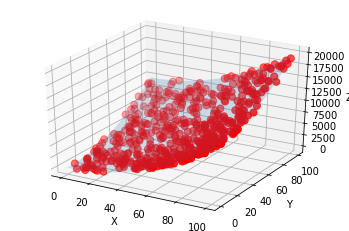

[[ 6.10984108e-11 -2.30073779e-12  1.00000000e+00]
 [-1.39979413e-12  4.04490635e-14 -2.62428909e-16]
 [ 1.00000000e+00 -3.47952285e-16  2.07893859e-18]]


In [2]:
n = 100
x, y = np.meshgrid(np.arange(n), np.arange(n))
z = x ** 2 + y ** 2
c = polyfit2d(x, y, z, degree=2, plot=True)
print(c)